In [1]:
import numpy as np
import random
from tqdm._tqdm_notebook import tqdm # for progress bars in notebook



C:\Users\Himansu Ganguli\AppData\Local\Temp\ipykernel_15112\606428152.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm # for progress bars in notebook


In [2]:
import os
import cv2
import pickle




In [7]:
def detect_faces(image):

    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    return faces

In [9]:
import os
import cv2
import numpy as np
from tqdm import tqdm

# Assuming detect_faces and apply_esrgan functions are already defined

datasets = ['train_ds', 'val_ds', 'test_ds']
extract_dir = 'dataset'  # Adjust this to your actual extract directory
output_dir = 'processed_images_128'  # Directory to save processed images

# Initialize lists for storing preprocessed images
train_preprocessed = []
val_preprocessed = []
test_preprocessed = []

train_labels = []
val_labels = []
test_labels = []

def load_images_and_labels(dataset):
    images = []
    labels = []
    dataset_path = os.path.join(extract_dir, dataset)
    people_folders = [f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))]

    progress_bar = tqdm(total=len(people_folders), desc=f'Processing {dataset}', unit='folder')

    for person_folder in people_folders:
        person_path = os.path.join(dataset_path, person_folder)
        image_files = [os.path.join(person_path, f) for f in os.listdir(person_path) if f.endswith('.jpg') or f.endswith('.png')]
        label = person_folder
        for image_path in image_files:
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            faces = detect_faces(image)

            for (x, y, w, h) in faces:
                # Extract the face ROI
                face_roi = image[y:y+h, x:x+w]

                # Convert to grayscale
                gray_face = cv2.cvtColor(face_roi, cv2.COLOR_BGR2GRAY)

                # Resize the face to the target size
                target_size = (128, 128)
                resized_face = cv2.resize(gray_face, target_size)

                # Save processed image
                filename = os.path.basename(image_path)
                output_path = os.path.join(output_dir, dataset, person_folder, filename)
                os.makedirs(os.path.dirname(output_path), exist_ok=True)
                cv2.imwrite(output_path, resized_face)

                images.append(resized_face)
                labels.append(label)
        
        progress_bar.update(1)

    progress_bar.close()
    return images, labels

# Call the function to load and process images
train_preprocessed, train_labels = load_images_and_labels('train_ds')
val_preprocessed, val_labels = load_images_and_labels('val_ds')
test_preprocessed, test_labels = load_images_and_labels('test_ds')

print("Image loading completed!")


Processing test_ds: 100%|██████████| 48/48 [01:55<00:00,  2.41s/folder]

Image loading completed!


# Extract EigenVectors

In [3]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        if os.path.isdir(file_path) or not file_path.endswith(('.png', '.jpg', '.jpeg')):
            continue
        img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img.flatten())
    return images


In [4]:
def compute_pca(images):
    # Compute mean image
    mean_image = np.mean(images, axis=0)
    
    # Initialize covariance matrix
    cov_matrix = np.zeros((mean_image.shape[0], mean_image.shape[0]))
    
    # Compute covariance matrix
    for image in tqdm(images, desc='Computing Covariance'):
        diff = image - mean_image
        cov_matrix += np.outer(diff, diff)
    cov_matrix /= (len(images) - 1)  # Normalize by N-1
    
    # Compute eigenvectors
    eig_vals, eig_vecs = np.linalg.eigh(cov_matrix)
    sorted_indices = np.argsort(-eig_vals)
    eig_vecs = eig_vecs[:, sorted_indices]
    
    # Return top k eigenvectors
    return eig_vecs

In [18]:
k=[30,40,50,60]

In [9]:
train_pairs.shape

(17263, 16384)

In [10]:
import pickle

In [11]:
eig_vecs = compute_pca(train_pairs)
with open(f'eig_vecsk_128.pkl', 'wb') as file:
    pickle.dump(eig_vecs, file)




Computing Covariance:   0%|          | 0/17263 [00:00<?, ?it/s]

# SVC Model

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [6]:
with open(f'eig_vecsk_128.pkl', 'rb') as file:
    eig_vecs = pickle.load(file)


In [8]:
# Function to project images using PCA eigenvectors
def project_images(image, k=60):
    # Images should be reshaped if they aren't already in (n_samples, n_features) format
    projected_images = np.dot(image, eig_vecs[:, :k])
    return projected_images

In [9]:
def generate_pairs(dataset_dir):
    pairs = []
    labels = []
    persons = os.listdir(dataset_dir)
    persons = [person for person in persons if os.path.isdir(os.path.join(dataset_dir, person))]
    
    for person in tqdm(persons):
        person_dir = os.path.join(dataset_dir, person)
        images = load_images_from_folder(person_dir)
        other_persons = [p for p in persons if p != person]
        
        if len(images) < 2:
            continue  # Skip if there are not enough images to form pairs
        
        #Generate all positive pairs
        for i in range(len(images)):
            main_image = project_images(images[i])
            j = random.choice([j for j in list(range(len(images))) if j != i])
            pairs.append((main_image, project_images(images[j])))
            labels.append(1)
            while True:
                other_person = random.choice(other_persons)
                other_person_dir = os.path.join(dataset_dir, other_person)
                other_images = load_images_from_folder(other_person_dir)
                if len(other_images) > 0:
                    break  # Ensure we get a non-empty list of images
                
            other_image = project_images(random.choice(other_images))
            pairs.append((main_image, other_image))
            labels.append(0)
            
    
    #Shuffle the pairs and labels together
    combined = list(zip(pairs, labels))
    random.shuffle(combined)
    pairs, labels = zip(*combined)
    
    return np.array(pairs), np.array(labels)


In [10]:
train_dir='processed_images_128/train_ds'
# test_dir='/Users/apoorvagayatrik/PerspectAIProj/processed_images_128/test_ds'
# val_dir='/Users/apoorvagayatrik/PerspectAIProj/processed_images_128/val_ds'

In [11]:
train_pairs, train_labels = generate_pairs(train_dir)
# val_pairs, val_labels = generate_pairs(val_dir)
# test_pairs, test_labels = generate_pairs(test_dir)
print(f"Generated {len(train_pairs)} pairs with {np.sum(train_labels)} positives and {len(train_labels) - np.sum(train_labels)} negatives")
# print(f"Generated {len(val_pairs)} pairs with {np.sum(val_labels)} positives and {len(val_labels) - np.sum(val_labels)} negatives")
# print(f"Generated {len(test_pairs)} pairs with {np.sum(test_labels)} positives and {len(test_labels) - np.sum(test_labels)} negatives")


  0%|          | 0/1695 [00:00<?, ?it/s]

Generated 34114 pairs with 17057 positives and 17057 negatives


In [12]:
train_pairs.shape

(34114, 2, 60)

In [14]:
train_pairs, test_pairs, train_labels, test_labels = train_test_split(
    train_pairs, train_labels, test_size=0.2, random_state=42
)

In [16]:
# Reshape train data: flatten each pair into one single vector
train_data_svc = train_pairs.reshape(-1, 120)  # 60 * 2 = 120

# Reshape test data similarly
test_data_svc = test_pairs.reshape(-1, 120)

In [27]:
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.svm import SVC

C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(kernel='rbf'), param_grid=param_grid, cv=cv)
grid.fit(train_data_svc, train_labels)

print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)

The best parameters are {'C': 10.0, 'gamma': 1e-08} with a score of 0.92


In [28]:
from sklearn.metrics import accuracy_score, classification_report

# Evaluate the best model on the test data
best_model = grid.best_estimator_
test_predictions = best_model.predict(test_data_svc)
print("Accuracy on test data: ", accuracy_score(test_labels, test_predictions))
print("Classification Report on test data:\n", classification_report(test_labels, test_predictions))

Accuracy on test data:  0.9292100249157262
Classification Report on test data:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93      3421
           1       0.92      0.94      0.93      3402

    accuracy                           0.93      6823
   macro avg       0.93      0.93      0.93      6823
weighted avg       0.93      0.93      0.93      6823



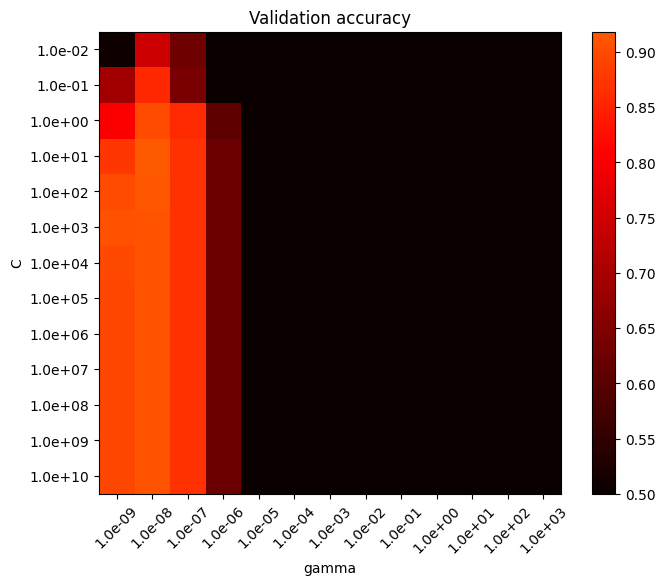

In [29]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# Visualization of the cross-validation scores
scores = grid.cv_results_['mean_test_score'].reshape(len(C_range), len(gamma_range))

class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

plt.figure(figsize=(8, 6))
plt.imshow(
    scores,
    interpolation='nearest',
    cmap=plt.cm.hot,
    norm=MidpointNormalize(vmin=np.min(scores), midpoint=0.92)
)
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), [f"{g:.1e}" for g in gamma_range], rotation=45)
plt.yticks(np.arange(len(C_range)), [f"{c:.1e}" for c in C_range])
plt.title('Validation accuracy')
plt.show()

In [30]:
import pickle

# Save the model to disk
model_filename = 'svc_rbf_c_10_gamma_1e-08.pkl'  # Specify your path here
with open(model_filename, 'wb') as file:
    pickle.dump(best_model, file)

print(f"Model saved to {model_filename}")

Model saved to svc_rbf_c_10_gamma_1e-08.pkl
